# Bollinger Bands Strategy
* Do not copy the code, understand it and code in your style.

## Import required packages below

---

In [ ]:
!pip install quandl
# Uncomment the above line if you are using colab
import numpy as np
import pandas as pd
import quandl as qdl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, Image

## Get data
---
You can either use 
1. Provided file
2. Quandl to load data of your choice
    * you can use "pip install quandl" in Command Prompt, search how to install packages using pip.
    * to make a quandl account and load data refer to this video
        - https://youtu.be/MpYRbbDTeZg
        - https://youtu.be/momk1LLABPI

In [ ]:
# your key goes in ""
api = qdl.ApiConfig.api_key = "Your Key"
# Watch the above videos to get a handle on operating the Quandl API 

In [ ]:
# Getting data of microsoft corporations from start_date to end date (Dates are in 'Y-M-D' format )
start = '2000-1-1'
end = '2020-1-1'
msft=qdl.get('EOD/MSFT',start_date=start,end_date=end)
msftCopy = msft
## MSFT is the ticker symbol for Microsoft Corporations which is listed on NASDAQ

In [ ]:
msft.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.484005,27.761009,27.085812,27.596538,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.172375,27.241626,26.929997,27.003576,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.921340,27.215657,26.791495,27.038201,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.103124,27.172375,26.947309,26.966354,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.025909,27.518631,27.007904,27.401769,49628500.0


## Explore the data
* Plot the data and note your observations
* Refer this https://plotly.com/python/candlestick-charts/

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=msft.index,
                                     open=msft['Open'],
                                     high=msft['High'],
                                     low=msft['Low'],
                                     close=msft['Close'])])
fig.show()

## Viewing a short window

In [ ]:
w_start=100
w_size=100
df=msft[w_start:w_start+w_size]
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['Open'],
                                     high=df['High'],
                                     low=df['Low'],
                                     close=df['Close'])])
fig.show()

## Why do you think this plot is better/not better than line plot?

## Lets see how rolling mean & standard deviation varies across data

In [ ]:
window_size=10
no_of_std = 1.5

#to implement our bollinger bands, we just need the rolling mean and the rolling standard-deviation

rolling_mean = msft['Close'].rolling(window_size).mean()
rolling_std = msft['Close'].rolling(window_size).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
msft['Rolling Mean'] = rolling_mean                                         #this column is the lower limit of upper band/ the upper limit of lower band
msft['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)           #this column is the upper limit of the upper band
msft['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)            #this column is the lower limit of the lower band 

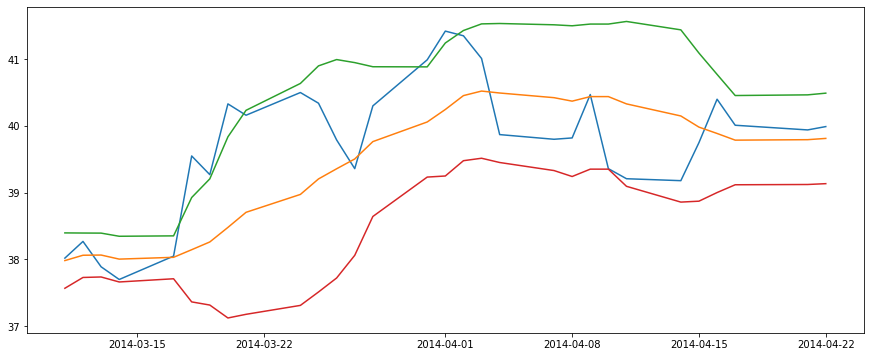

In [ ]:
w_start=130
w_size=30
df=msft[w_start:w_start+w_size]
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['Rolling Mean'],
                                     high=df['Bollinger High'],
                                     low=df['Bollinger Low'],
                                     close=df['Close'])])
fig.show()

plt.figure(figsize=(15,6))
plt.plot(df['Close'])
plt.plot(df['Rolling Mean'])
plt.plot(df['Bollinger High'])
plt.plot(df['Bollinger Low'])
plt.show()

## What pattern do you see in Candle stick plot corresponding to line plot which can spot if we have over priced or under priced stock ( as per bollinger band )?

## Mechanics of Placing an order

1. We generate a signal whenever the Bollinger Bands are breached

2. Order is placed in market and depending on the market conditions order is either fullfilled or not

3. Once order is fullfilled we enter into the position as consequence of the order

4. For keeping this strategy simple, we have limited our maximum position to 1. That is we cannot have more than +1 or -1 position at any given point in time.

5. Thus thus if we generate consecutive signals having the same sign, we only consider the first such signal as a true signal and use it to enter a position in the market.

##### We will assume that all of our orders are fullfilled instantaniously, which may not be the case when actually used for trading
##### For more details search : Market Microstructure



```
# This is formatted as code
```

### Building the strategy

---

##### Filling Signal & Position column based on the following rules:
  * set Signal to short (-1) when the price hits the upper band and Position will change accordingly to (-1) or (0)
       i.e. either short position or no position(i.e we have exited a long position)
  * set Signal to long (1) when it hits the lower band and Position will change accordingly to (1) or (0)
       i.e. either long position or no position(i.e we have exited a short position)
  * set Signal to 0 if the price is between upper and lower bands

In [ ]:
# create a new column in the DataFrame to hold signal information
msft['Signal'] = None
msft['Position'] = None

mode = 'neutral'
for index in range(len(msft)):
    if index == 0:
        continue

    row = msft.iloc[index]
    prev_row = msft.iloc[index - 1]

    ## Entering a position (i.e either going long or going short with our money)

    '''
    mode shows the current position taken in the portfolio (helps us keep track of the positions taken)
    So, mode = neutral, means no position is active, i.e neither long nor short i.e we are all in cash
        mode = long, means we are long (bullish) on the stock at the moment 
        mode = short, means we are short(bearish) on the stock at the moment
    '''    


    '''
    see the if statements and notice how the algo is going to decide whether the Signal = 1 or Signal = -1
    for example, let's discuss what happens when we are entering a long position
    we check if mode == 'neutral', so that we dont enter long position again when a position is already active
    we then check row['Close'] < row['Bollinger Low'], because we want the 'Bollinger low' to be broken by the current 'Close' price to enter a long position
    we then check prev_row['Close'] > prev_row['Bollinger Low'], because we want to make sure we haven't already generated a similar buy signal in the previous candle-stick
    '''


    # Entering a long position (intutively understand how Signal = 1, tells us to go long, i.e Position = 1)
    if mode == 'neutral' and row['Close'] < row['Bollinger Low'] and prev_row['Close'] > prev_row['Bollinger Low']:
        msft.iloc[index, msft.columns.get_loc('Signal')] = 1
        msft.iloc[index, msft.columns.get_loc('Position')] = 1
        mode = 'long'

    # Entering a short position (similarly Signal = -1, tells us to go short, i.e Position = -1)
    elif mode == 'neutral' and row['Close'] > row['Bollinger High'] and prev_row['Close'] < prev_row['Bollinger High']:
        msft.iloc[index, msft.columns.get_loc('Signal')] = -1
        msft.iloc[index, msft.columns.get_loc('Position')] = -1
        mode = 'short'

    ## Exiting a long position
    elif mode == 'long' and row['Close'] > row['Bollinger High']:
        msft.iloc[index, msft.columns.get_loc('Signal')] = -1
        msft.iloc[index, msft.columns.get_loc('Position')] = 0
        mode = 'neutral'

    # Exiting a short position
    elif mode == 'short' and row['Close'] < row['Bollinger Low']:
        msft.iloc[index, msft.columns.get_loc('Signal')] = 1
        msft.iloc[index, msft.columns.get_loc('Position')] = 0
        mode = 'neutral'    
    
    else:
      ## If no signal is generated, we retain the previous position
      msft.iloc[index, msft.columns.get_loc('Position')] = msft.iloc[index-1, msft.columns.get_loc('Position')]

## Stock price when each signal was generated 

---

Here, we have calculated the stock price whenever we have generated a signal. The jagged structure shows this.

Note : We will slowly modify our 'Returns' column to actually contain returns of our strategy, we are stopping in between and displying to help understand the process

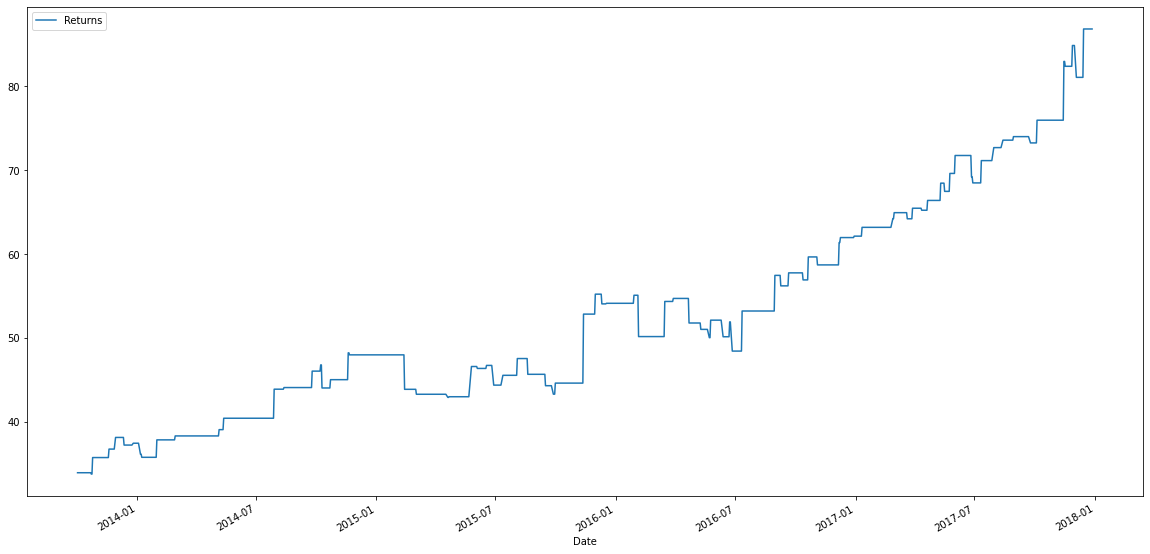

In [ ]:
msft['Returns']=msft['Signal']**2*msft['Close']
msft['Returns'].fillna(method='ffill', inplace=True)
_=msft[['Returns']].plot(figsize=(20,10))


## Signal lines with stock price at each signal

---

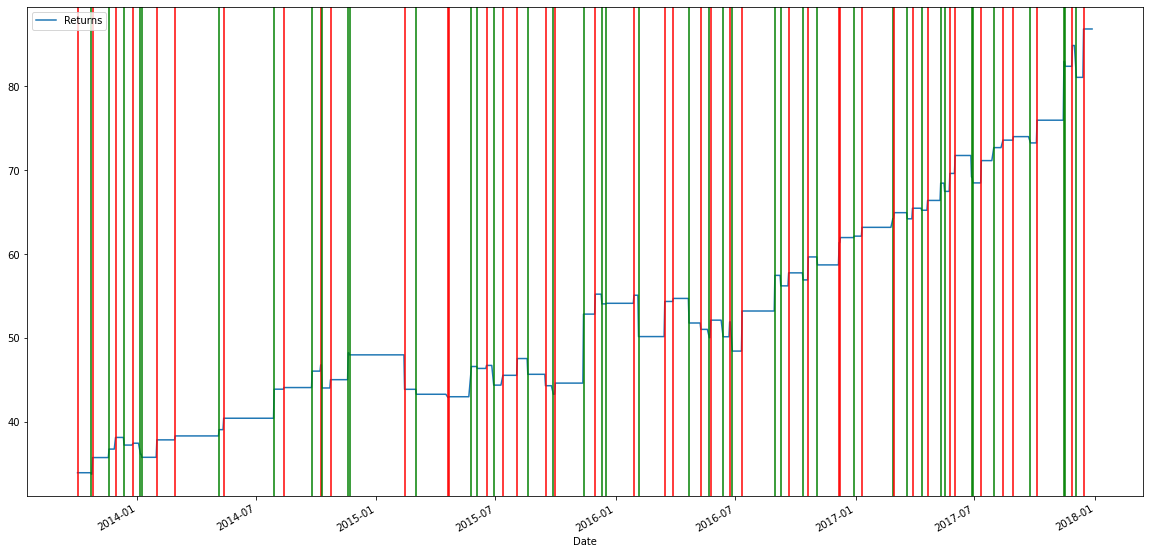

In [ ]:
_=msft[['Returns']].plot(figsize=(20,10))
for index, pos in msft['Signal'].iteritems():
    ## Using Green for Buy
    if pos == 1:
      plt.axvline(index, color='green')
    ## Using Red for Sell
    elif pos == -1:
      plt.axvline(index, color='red')

##  What can you infer from the graph below?

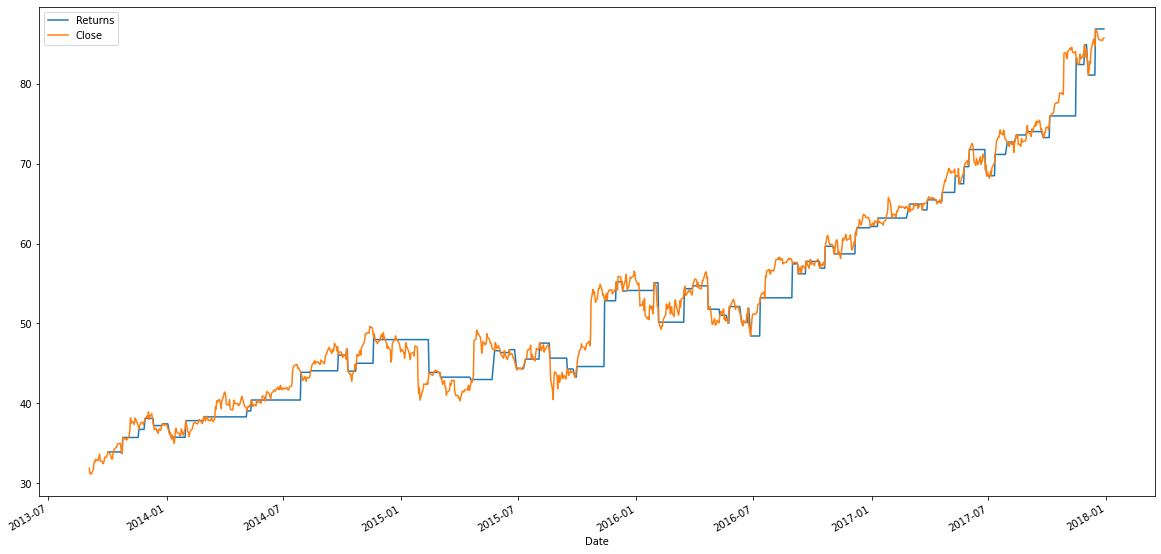

In [ ]:
_=msft[['Returns','Close']].plot(figsize=(20,10))

## Now we actually calculate the return and aggregate it according to our positions
---

* example, say if stock price increases by 5% but we went short on it so our position was -1 so we actually made 5% loss, and vice versa 

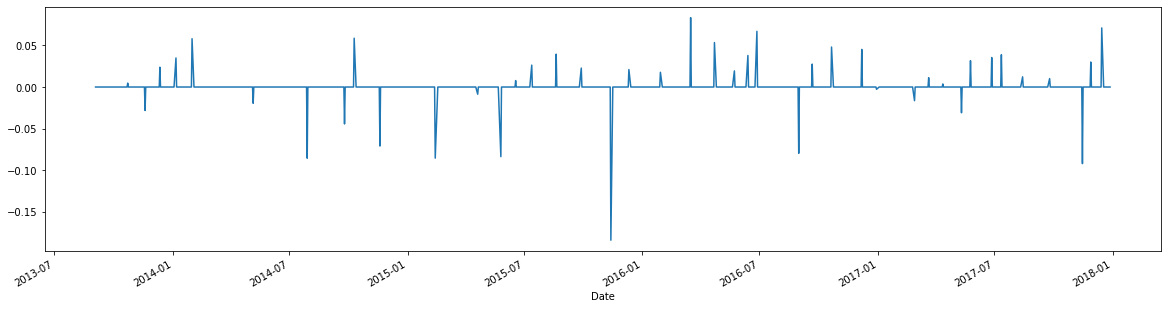

In [ ]:
msft['Returns']=msft['Returns'].pct_change()*msft['Position'].shift() 
msft['Returns']=msft['Returns'].fillna(value=0)
_=msft['Returns'].plot(figsize=(20,5))
# Saving the below plot
plt.savefig("Returns.png")

## What if you invested according to this strategy?
---

* Lets say you have 100 Million rupees invested in this share
* And you invest according to this strategy
* No matter if make loss or gain you reinvest all the value of stock after each return back into this stock  as per the strategy
* This is how your 100 Million rupees would change!

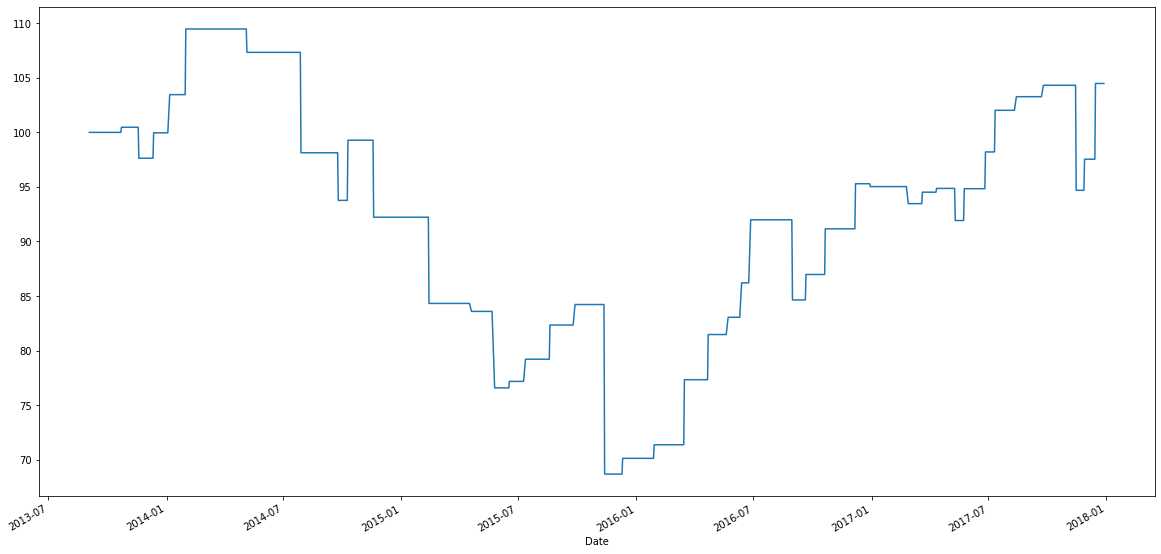

In [ ]:
# 'cumprod()' just calculates the compounded product of the series
msft['portfolio']=100*(1+msft['Returns']).cumprod()
_=msft['portfolio'].plot(figsize=(20, 10))

So you can clearly see that we have made net profit, by the end of 2017, we are  left with 105 Million as against our initial capital of 100 Million

In [ ]:
returns = msft['Returns'].dropna()
# Removing all the zero returns i.e. where we never traded
returns=returns[returns!=0]
print('Max return %: '+str((100*max(returns)).__round__(2)),'Min return %: '+str((100*min(returns)).__round__(2)),'Average return %: '+str((100*np.mean(returns)).__round__(2)),sep='\n')

Max return %: 8.35
Min return %: -18.45
Average return %: 0.26


# Hyper parameter tuning for this strategy
---
In order to find optimal parameters, we need a metric to compare different configurations of a strategy.
* Sharpe Ratio
    * https://www.investopedia.com/terms/s/sharperatio.asp
    * https://blog.quantinsti.com/sharpe-ratio-applications-algorithmic-trading/
* You can also try other metrics
    * Refer this http://quantfiction.com/2018/08/20/trading-metrics-that-actually-matter/
    * For more details google : Backtesting Metrics

In [ ]:
# we are assuming 0 as risk free return 
# which is certainly not the real case but this assumption shall not make that big of a difference, or will it?
sharpe_ratio=returns.mean()/(returns.var())**(1/2)
print("Sharpe Ratio: "+str(sharpe_ratio))

Sharpe Ratio: 0.04716392092632901


* Performance of strategy depends on the parameters that we have assumed, here we have **size of windows** and **number of standard deviations**.
* We will be using **Grid Search**, refer to the github link.
* You can try other methods like **Random Search**
* Refer this for more details on different methods https://en.wikipedia.org/wiki/Hyperparameter_optimization

## Building a class for simulating the strategy
---
Before we can configure hyper parameters we would actually need to make a callable class for this strategy

In [ ]:
class BollingerBandsSimulator:

    def __init__(self, df_original, from_date, window_size, no_of_std, figsize=(20,10)):
        self.df = df_original
        self.from_date = from_date
        self.window_size = window_size
        self.no_of_std = no_of_std
        self.figsize = figsize
        self.sharpe_ratio = None
        self.returns = None
                
    def _build_bollinger_bands(self):
        rolling_mean = self.df['Close'].rolling(self.window_size).mean()
        rolling_std = self.df['Close'].rolling(self.window_size).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)

    def _calculate_positions(self):
        # create a new column in the DataFrame to hold signal information
        self.df['Signal'] = None
        self.df['Position'] = None

        mode = 'neutral'
        for index in range(len(msft)):
            if index == 0:
                continue

            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]

            ## Entering a position

            # long
            if mode == 'neutral' and row['Close'] < row['Bollinger Low'] and prev_row['Close'] > prev_row['Bollinger Low']:
                self.df.iloc[index, self.df.columns.get_loc('Signal')] = 1
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1
                mode = 'long'

            # short
            elif mode == 'neutral' and row['Close'] > row['Bollinger High'] and prev_row['Close'] < prev_row['Bollinger High']:
                self.df.iloc[index, self.df.columns.get_loc('Signal')] = -1
                self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
                mode = 'short'

            ## Exiting a position
            elif mode == 'long' and row['Close'] > row['Bollinger High']:
                self.df.iloc[index, self.df.columns.get_loc('Signal')] = -1
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0
                mode = 'neutral'

            # short
            elif mode == 'short' and row['Close'] < row['Bollinger Low']:
                self.df.iloc[index, self.df.columns.get_loc('Signal')] = 1
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0
                mode = 'neutral'    

            else:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = self.df.iloc[index-1, self.df.columns.get_loc('Position')]        

    def _calculate_returns(self):
        self.df['Returns']=self.df['Signal']**2*self.df['Close']
        self.df['Returns'].fillna(method='ffill', inplace=True)
        self.df['Returns']=self.df['Returns'].pct_change()*self.df['Position'].shift()
        self.df['Returns']=self.df['Returns'].fillna(value=0)
        self.returns = self.df['Returns'].dropna()
        # Removing all the zero returns i.e. where we never traded
        self.returns=self.returns[self.returns!=0]
        self.sharpe_ratio = self.returns.mean()/(self.returns.var())**(1/2)
        

    def _plot_returns(self):
        self.df['Returns'].cumsum().plot(figsize=self.figsize)

    def simulate(self):
        self._build_bollinger_bands()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()

        return (
            self.window_size, 
            self.no_of_std, 
            self.sharpe_ratio
        )

(10, 1.5, 0.04716392092632901)

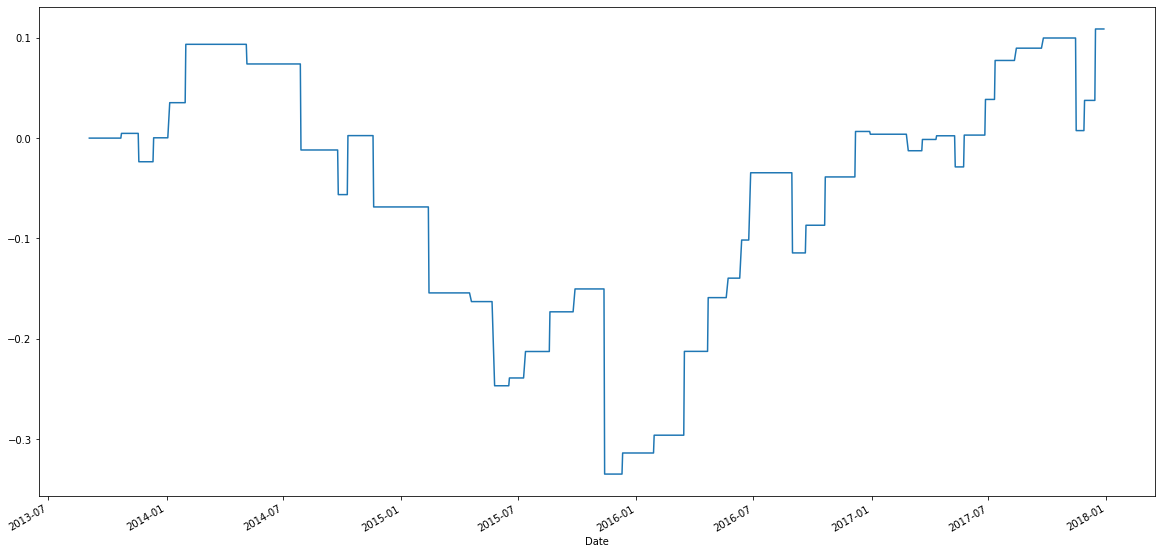

In [ ]:
simulator = BollingerBandsSimulator(
    df_original=msft, 
    from_date="2014-01-01", 
    window_size=10, 
    no_of_std=1.5
)
simulator.simulate()
# The graph shows that we have a net return of 60% in 5 years

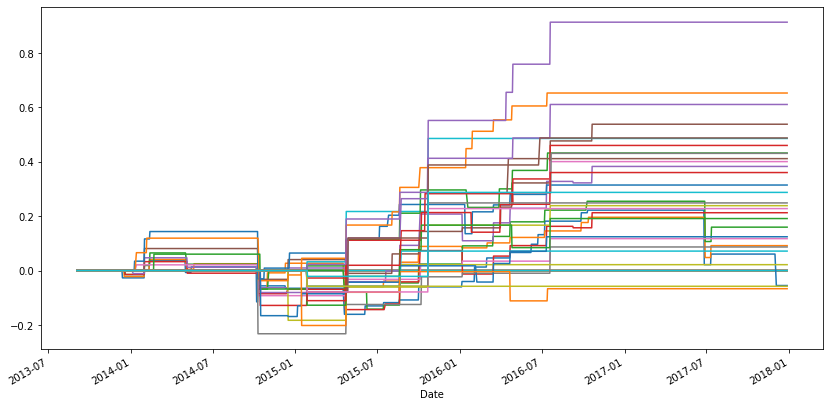

In [ ]:
# generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
windows = np.linspace(1, 100, 4, dtype=int)
stds = np.linspace(0.5, 3, 10)

result_df = pd.DataFrame({
    'window': [],
    'no_of_std': [],
    'result': []
})

for window in windows:
    for std in stds:
        simulator = BollingerBandsSimulator(
            df_original=msft, 
            from_date="2014-02-11", 
            window_size=window, 
            no_of_std=std,
            figsize=(14, 7)
        )
        window, no_of_std, result = simulator.simulate()
        result_df = result_df.append({
            'window': window, 
            'no_of_std': no_of_std, 
            'result': result
        }, ignore_index=True)

In [ ]:
## Displaying the top 3 results
result_df.sort_values(by=['result'], ascending=False)[0:3]

,window,no_of_std,result
19,34.0,3.000000,1.351078
24,67.0,1.611111,1.179835
34,100.0,1.611111,1.048830


### Visualization results on strategy parameters
---
Brighter the color higher the value for our metric, ignore the region in which we don't have data points

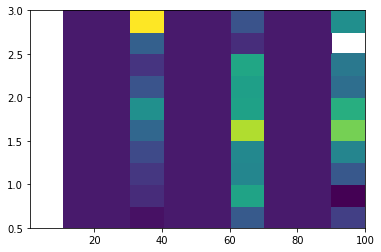

In [ ]:
_=plt.hist2d(x=result_df['window'],y=result_df['no_of_std'],weights=result_df['result'])

## The above plot suggests that we should increase the window size and reduce standard deviation bound for the Bollinger bands. Can you think why?

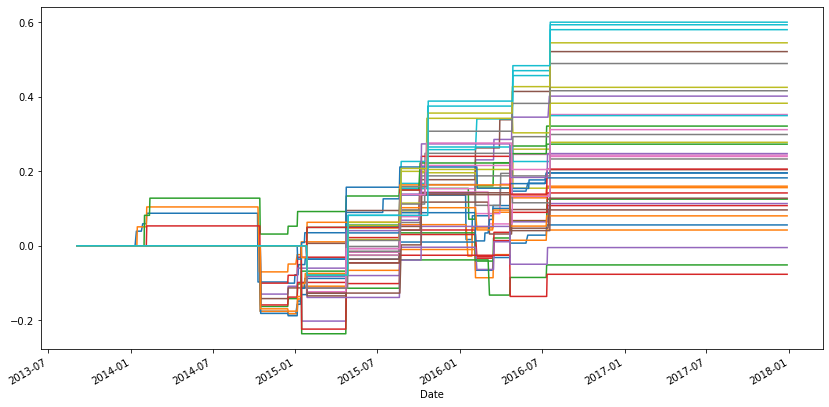

In [ ]:
# generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
windows = np.linspace(80, 120, 4, dtype=int)
stds = np.linspace(0.2, 1.5, 10)

result_df2 = pd.DataFrame({
    'window': [],
    'no_of_std': [],
    'result': []
})

for window in windows:
    for std in stds:
        simulator = BollingerBandsSimulator(
            df_original=msft, 
            from_date="2014-02-11", 
            window_size=window, 
            no_of_std=std,
            figsize=(14, 7)
        )
        window, no_of_std, result = simulator.simulate()
        result_df2 = result_df2.append({
            'window': window, 
            'no_of_std': no_of_std, 
            'result': result
        }, ignore_index=True)

In [ ]:
## Displaying the top 3 results
result_df2.sort_values(by=['result'], ascending=False)[0:3]

,window,no_of_std,result
32,120.0,0.488889,1.692051
29,106.0,1.500000,1.098806
38,120.0,1.355556,1.032642


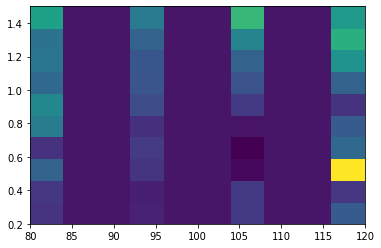

In [ ]:
_=plt.hist2d(x=result_df2['window'],y=result_df2['no_of_std'],weights=result_df2['result'])

Now you can see that we have got very decent parameters for this strategy!
But turns out that Hyperparameter tuning is not really a good idea.

For those of you who might be familiar with the concept of overfitting would know the reason

Read more about this here: https://algotrading101.com/learn/what-is-overfitting-in-trading/#:~:text=Overfitting%20in%20trading%20is%20the,your%20strategy%20will%20be%20profitable.

## Volatility Filter
---
Lets look at a sample bollinger band strategy with window 30 and std = 1.5, we then study the distribution of returns wrt to the volatility levels.

(30, 1.5, 0.014033155545913405)

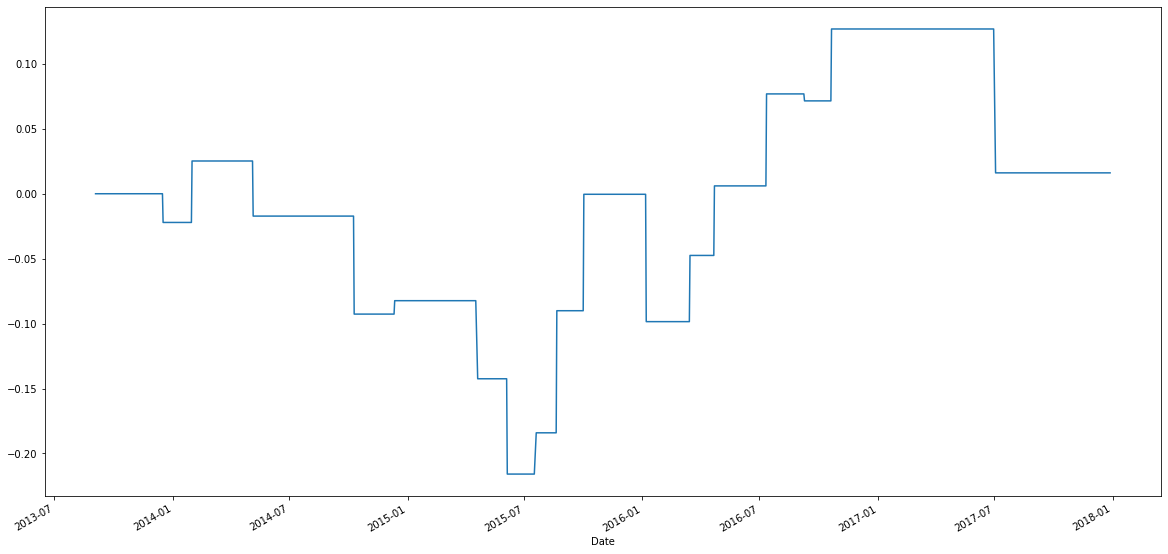

In [ ]:
simulator = BollingerBandsSimulator(
    df_original=msftCopy, 
    from_date="2014-01-01", 
    window_size=30, 
    no_of_std=1.5
)
simulator.simulate()

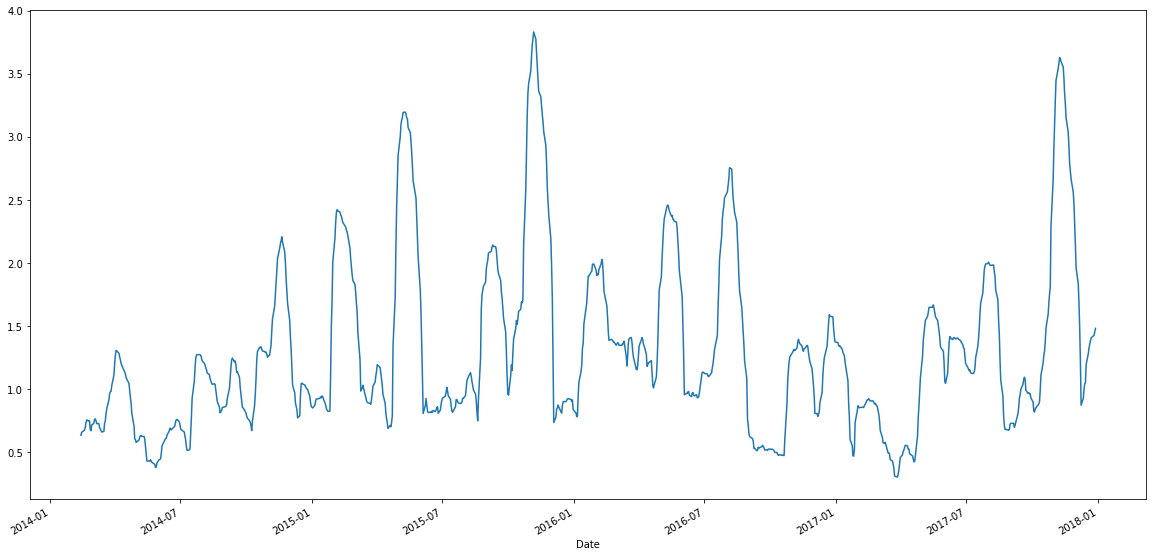

In [ ]:
msftCopy['Close'].loc["2014-01-01":].rolling(30).std().dropna().plot(figsize=(20, 10))

Now, if you compare the region for which our returns turn negative, its clearly visible from the above plot of standard deviation of MSFT price that the negative return region directly corresponds to the region when the stock volatility was very high. This suggests we can put a volatility filter on our strategy to cut our losses. What you saw above is one of the ways to improve a trading strategy. One of the most important part of the job is to analyse the conditions when a given strategy does not work and turn the on/off accordingly.

## Lets revisit the calculated returns from the untuned strategy
---



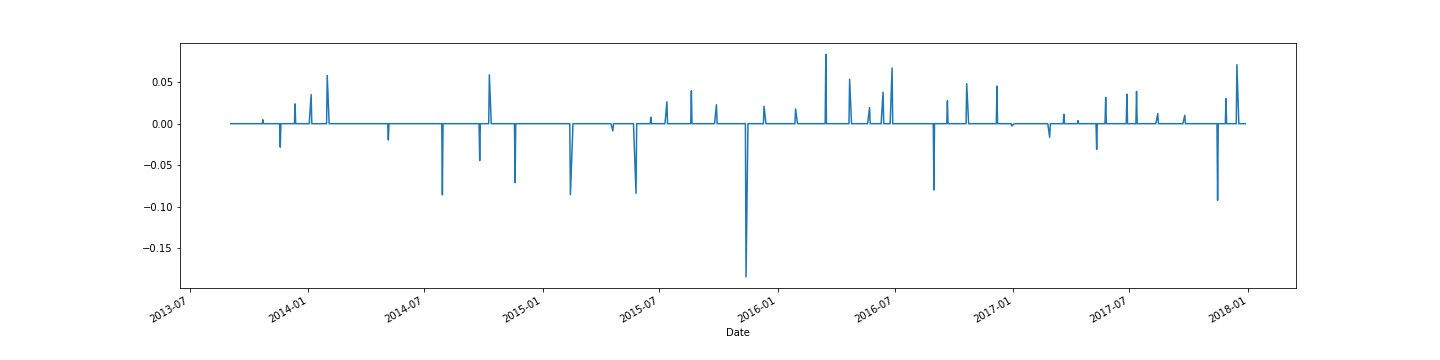

In [ ]:
display(Image(filename='Returns.png'))

We can clearly see huge negative spikes, which suggests that perhaps there is a problem with our model!

The problem with the above model is the we have assumed the price to be mean reverting to long term averages for the logic to Bollinger band to hold. But what if it is not the case! When there is very strong trend in the market, stock price series might not revert back to the mean for a very long period of time thus resulting in huge negative losses. For more details $\to$ Google!

## Hands On Task
---
We want you to integrate the above idea of percentage returns in the strategy. That is use the code for the **Bollinger Simulator** given above and append its logic such that we use the percentage return in price instead of the absolute price to compute our [+1,0,-1] signals

If you implement it do submit it at the QC mail id "quantclubiitkgp@gmail.com" with proper commenting and plots showing improvement in the returns.